In [28]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [29]:
# customize imports
import math

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as opt

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime

# Data

In [30]:
# explore dataset from csv
skin_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv')

skin_df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,172,171,173,175,164,187,207,210,208,206,...,210,217,221,209,185,187,192,192,192,0
10011,2,34,108,116,114,119,131,139,139,145,...,173,169,168,168,143,138,83,23,3,0
10012,122,154,162,170,179,197,200,195,202,199,...,221,215,205,187,209,198,187,164,156,0
10013,137,143,141,139,147,152,155,152,155,159,...,172,171,175,183,177,170,169,166,170,0


In [31]:
# getting labels number
skin_label_df = skin_df['label']

skin_label_dict = {}
sl_values = set()

for i, v in skin_label_df.items():
    if v not in sl_values:
        skin_label_dict[i] = v
        sl_values.add(v)

sl_values

{0, 1, 2, 3, 4, 5, 6}

In [32]:
# getting pixel from dataframe columns round square
pixel = int(math.sqrt(skin_df.shape[1]))

pixel

28

In [33]:
# img size
img_row, img_col = pixel, pixel

# number of img classes
nbr_class = len(list(sl_values))

print(f"image: {img_row} x {img_col} pixels")
print(f"labels: {nbr_class} classes")

image: 28 x 28 pixels
labels: 7 classes


In [34]:
# convert skin df into np
skin_np = skin_df.to_numpy()

skin_np.shape

(10015, 785)

In [35]:
# separating data col into categories
labels = np.array(skin_np[:, -1])
images = np.array(skin_np[:, :-1])

labels.shape, images.shape

((10015,), (10015, 784))

In [36]:
# reshape images into cv acceptable format
images_28px = images.reshape(-1, 1, 28, 28)

images_28px.shape

(10015, 1, 28, 28)

In [37]:
# normalize the images
images_28px_normalize = images_28px.astype(np.float32) / 255.0

# output single datapoint to check the normalization
images_28px_normalize[:1, -1, :1, :1]

array([[[0.6627451]]], dtype=float32)

In [38]:
# check for gpu device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# converting data into torch dtype for future model
imgs_torch = torch.tensor(images_28px_normalize).to(device)
labels_torch = torch.tensor(labels, dtype=torch.long).to(device)

imgs_torch.shape, labels_torch.shape

(torch.Size([10015, 1, 28, 28]), torch.Size([10015]))

In [39]:
# splitting data into train and test section
x_train, x_test, y_train, y_test = train_test_split(
    imgs_torch, labels_torch, test_size=0.1, random_state=42
)

print(f"training data: {x_train.shape, y_train.shape},\ntesting data: {x_test.shape, y_test.shape}")

training data: (torch.Size([9013, 1, 28, 28]), torch.Size([9013])),
testing data: (torch.Size([1002, 1, 28, 28]), torch.Size([1002]))


In [40]:
# batch data into dataset
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

len(train_dataset), len(test_dataset)

(9013, 1002)

In [41]:
# format the image data for plotting
plt_train_0 = train_dataset[0][0].squeeze(0).cpu().numpy()
plt_train_last = train_dataset[-1][0].squeeze(0).cpu().numpy()

plt_train_0.shape, plt_train_last.shape

((28, 28), (28, 28))

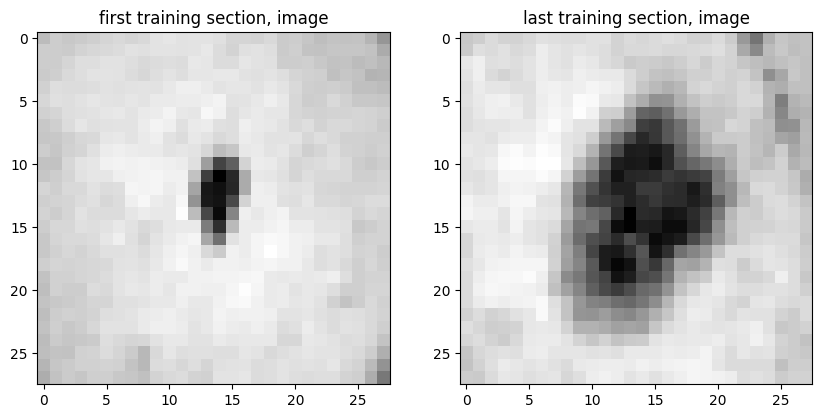

In [42]:
# plotting two images into one figure
figure, axes = plt.subplots(1, 2, figsize=(10, 5))

# fst image
axes[0].set_title("first training section, image")
axes[0].imshow(plt_train_0, cmap="gray")

# sec imge
axes[1].set_title("last training section, image")
axes[1].imshow(plt_train_last, cmap="gray")

In [43]:
# data augmentation pipeline
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# data augmentation class
class DataAugmentation(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            #np_img = np.array(image.cpu())
            image = self.transform(image)
        return image, label

# augmented dataset
aug_train_dataset = DataAugmentation(x_train, y_train, transform=train_transform)
aug_test_dataset = DataAugmentation(x_test, y_test, transform=test_transform)

# prepare data loaders for training
aug_train_loader = DataLoader(aug_train_dataset, shuffle=True, batch_size=128)
aug_test_loader = DataLoader(test_dataset, shuffle=True, batch_size=128)

# Model

In [44]:
# test to flatten data
ts = torch.Tensor(1, 64, 64)

ts.view(ts.size(0), -1).shape

torch.Size([1, 4096])

In [45]:
# cnn model implemented by julio, inspired by vgg
class JulioCnn(nn.Module):
    def __init__(self):
        super(JulioCnn, self).__init__()
        self.conv = nn.Sequential( # 1x28x28
            #  block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 32x14x14
            nn.Dropout(0.25),
            # block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 64x7x7
            nn.Dropout(0.25),
            # block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 7), # 7 classes
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
# invoke model
model = JulioCnn().to(device)
# model.load_state_dict(torch.load('/kaggle/working/model_20250301_123923.pth'))
criterion = nn.CrossEntropyLoss()
optim = opt.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [46]:
# test device situation
print(device)

cuda


# Model Architecture

In [47]:
def model_summary(model):
    print('Model Architecture General')
    print(model)

    print('Model Layers Details')
    for name, layer in model.named_children():
        print(f'Layer name: {name}, type: {type(layer)}')
        if hasattr(layer, 'weight') and layer.weight is not None:
            print(f'Layer weight: {layer.weight.shape}')
        if hasattr(layer, 'bias') and layer.bias is not None:
            print(f'Layer bias: {layer.bias.shape}')

    print('Model Parameters')
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')

model_summary(model)

Model Architecture General
JulioCnn(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15):

# Model 2

In [48]:
# cnn model implemented by julio, inspired by vgg
class JulioCnn2(nn.Module):
    def __init__(self):
        super(JulioCnn2, self).__init__()
        self.conv = nn.Sequential( # 1x28x28
            #  block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), # 32x14x14
            nn.Dropout(0.10),
            # block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), # 128x7x7
            nn.Dropout(0.15),
            # block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), # 128x3x3
            nn.Dropout(0.25),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Dropout(0.35),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 7), # 7 classes
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
# invoke model
model2 = JulioCnn2().to(device)
# model.load_state_dict(torch.load('/kaggle/working/model_20250301_123923.pth'))
criterion2 = nn.CrossEntropyLoss()
optim2 = opt.AdamW(model2.parameters(), lr=1e-3, weight_decay=1e-4)

# Model 2 Architecture

In [49]:
model_summary(model2)

Model Architecture General
JulioCnn2(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ELU(alpha=1.0)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

# Evaluation Metrics

In [50]:
# before training aka b.t.
# after training aka a.t.

# values to be tracked
bt_acc_v = 0.
at_acc_v = 0.

# accuracy to be tracked
bt_acc = []
at_acc = []

# loss metric before training
bt_criterion = nn.CrossEntropyLoss()

# calculate accuracy function
def calculate_acc(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    corrects = (preds == labels).sum()
    acc = corrects / len(labels)
    return acc.item()

# Evaluation (B.T.)

In [51]:
# activate model evaluation
model.eval()

# loop through the batches test files
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        bt_acc.append(calculate_acc(outputs, labels))

bt_acc

[0.109375,
 0.140625,
 0.1015625,
 0.109375,
 0.125,
 0.1328125,
 0.171875,
 0.1037735864520073]

In [52]:
# activate model 2 evaluation
model2.eval()
bt_acc2 = []

# loop through the batches test files
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model2(images)
        bt_acc2.append(calculate_acc(outputs, labels))

bt_acc2

[0.0390625,
 0.0,
 0.0,
 0.0078125,
 0.0234375,
 0.0078125,
 0.0234375,
 0.01886792480945587]

# Train

In [53]:
# train model
model.train()

epochs = 1000
loss_history = []

for ep in range(epochs):
    losses = 0.
    total_labels = 0
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        optim.zero_grad()
        prediction = model(img)
        loss = criterion(prediction, label)
        loss.backward()
        optim.step()
        losses += loss.item() * img.size(0)
        total_labels += label.size(0)
    if ep % 50 == 0:
        #print(losses)
        #print(total_labels)
        losses_perc = losses / total_labels
        loss_history.append(losses_perc)
    if ep % 100 == 0:
        print(f"epoch {ep}, loss perc: {losses_perc:.4f}")

epoch 0, loss perc: 1.1719
epoch 100, loss perc: 0.1247
epoch 200, loss perc: 0.0786
epoch 300, loss perc: 0.0635
epoch 400, loss perc: 0.0577
epoch 500, loss perc: 0.0613
epoch 600, loss perc: 0.0513
epoch 700, loss perc: 0.0536
epoch 800, loss perc: 0.0565
epoch 900, loss perc: 0.0442


In [54]:
# train model 2
model2.train()

epochs = 1000
loss_history2 = []

for ep in range(epochs):
    losses = 0.
    total_labels = 0
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        optim2.zero_grad()
        prediction = model2(img)
        loss = criterion2(prediction, label)
        loss.backward()
        optim2.step()
        losses += loss.item() * img.size(0)
        total_labels += label.size(0)
    if ep % 50 == 0:
        losses_perc = losses / total_labels
        loss_history2.append(losses_perc)
    if ep % 100 == 0:
        print(f"epoch {ep}, loss perc: {losses_perc:.4f}")

epoch 0, loss perc: 1.3981
epoch 100, loss perc: 0.0381
epoch 200, loss perc: 0.0264
epoch 300, loss perc: 0.0168
epoch 400, loss perc: 0.0121
epoch 500, loss perc: 0.0125
epoch 600, loss perc: 0.0059
epoch 700, loss perc: 0.0121
epoch 800, loss perc: 0.0051
epoch 900, loss perc: 0.0072


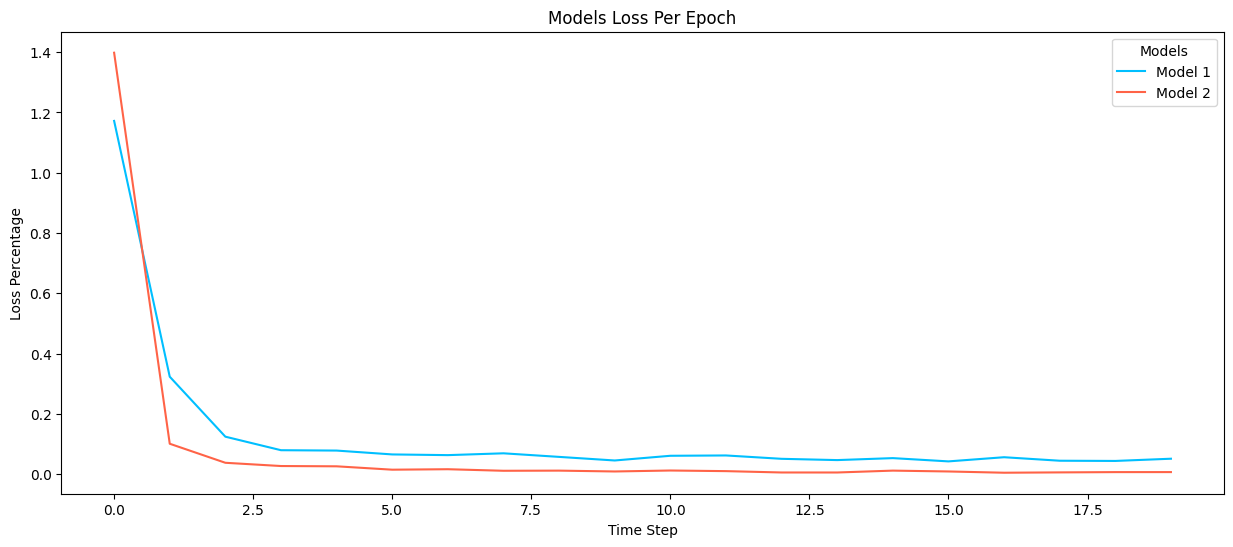

In [55]:
# plot out a comparative losses of model 1 and model 2
plt.figure(figsize=(15, 6))
plt.plot(loss_history, color='deepskyblue', label='Model 1')
plt.plot(loss_history2, color='tomato', label='Model 2')
plt.title('Models Loss Per Epoch')
plt.xlabel('Time Step')
plt.ylabel('Loss Percentage')
plt.legend(title='Models')
plt.show()

# Save Model

In [56]:
# create models directory if not exists
os.makedirs('models', exist_ok=True)

# time
time = datetime.now().strftime('%Y%m%d_%H%M%S')

# training last loss point
llp = losses / len(train_loader)

# model name
model_name = f'models/model_{time}_{llp}.pth'

# save model
torch.save(model.state_dict(), model_name)
print(f'Model saved, {model_name}')

Model saved, models/model_20250310_232909_0.7226391924638629.pth


# Evaluation 1 (A.T.)

In [57]:
# evaluate model with training
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        acc = calculate_acc(outputs, labels)
        at_acc.append(acc)

at_acc

[0.6796875,
 0.6640625,
 0.7734375,
 0.6875,
 0.65625,
 0.6796875,
 0.703125,
 0.801886796951294]

In [58]:
# evaluate model 2 with training
model2.eval()
at_acc2 = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model2(images)
        acc = calculate_acc(outputs, labels)
        at_acc2.append(acc)

at_acc2

[0.7109375,
 0.6875,
 0.7421875,
 0.6796875,
 0.6640625,
 0.7109375,
 0.71875,
 0.7735849022865295]

# Evaluation 2 (A.T.)

In [59]:
with torch.no_grad():
    y_pred = model(x_test)

y_pred_int = y_pred.argmax(axis=1).cpu().numpy()
y_test_int = y_test.cpu().numpy()

# ground truth
print(f'predicted class: {y_pred_int[1]}')
print(f'true class: {y_test_int[1]}')

predicted class: 6
true class: 4


In [60]:
# confusion matrix
conf = confusion_matrix(y_test_int, y_pred_int)

conf

array([[  9,   5,  13,   0,   7,   0,   7],
       [  4,  25,   5,   1,   6,   0,   6],
       [  5,   5,  36,   0,  53,   1,  25],
       [  1,   2,   2,   3,   5,   0,   2],
       [  1,  10,  22,   0, 583,   1,  32],
       [  1,   0,   0,   0,  12,   1,   1],
       [  2,   5,  14,   0,  41,   0,  48]])

In [61]:
# classfication report
report = classification_report(y_test_int, y_pred_int, zero_division=0)

print(report)

              precision    recall  f1-score   support

           0       0.39      0.22      0.28        41
           1       0.48      0.53      0.51        47
           2       0.39      0.29      0.33       125
           3       0.75      0.20      0.32        15
           4       0.82      0.90      0.86       649
           5       0.33      0.07      0.11        15
           6       0.40      0.44      0.42       110

    accuracy                           0.70      1002
   macro avg       0.51      0.38      0.40      1002
weighted avg       0.68      0.70      0.69      1002



In [62]:
# model 2 prediction for report
with torch.no_grad():
    y_pred = model2(x_test)

y_pred_int = y_pred.argmax(axis=1).cpu().numpy()
y_test_int = y_test.cpu().numpy()

# classfication report 2
report2 = classification_report(y_test_int, y_pred_int, zero_division=0)

print(report2)

              precision    recall  f1-score   support

           0       0.30      0.32      0.31        41
           1       0.51      0.40      0.45        47
           2       0.42      0.35      0.38       125
           3       0.67      0.13      0.22        15
           4       0.82      0.91      0.86       649
           5       0.00      0.00      0.00        15
           6       0.45      0.36      0.40       110

    accuracy                           0.71      1002
   macro avg       0.45      0.35      0.38      1002
weighted avg       0.68      0.71      0.69      1002



# Evaluation 3 (A.T.)

In [63]:
# virtual bt_cc/at_acc to simulate after training, in order to test plotting
v_bt_acc = [0.9, 1.4, 1.8]
v_at_acc = [1.2, 0.8, 0.7]

In [64]:
# calculate perfomance history based on tracked accuracies
bt_perm = []
at_perm = []

# values to be summed
total_bt, total_at = 0., 0.

for i, (b, a) in enumerate(zip(bt_acc, at_acc)):
    it = i + 1
    
    total_bt += b
    total_at += a
    
    perm_bt = total_bt / it
    perm_at = total_at / it
    
    bt_perm.append(perm_bt)
    at_perm.append(perm_at)

print(bt_perm)
print(at_perm)

[0.109375, 0.125, 0.1171875, 0.115234375, 0.1171875, 0.11979166666666667, 0.12723214285714285, 0.12429982330650091]
[0.6796875, 0.671875, 0.7057291666666666, 0.701171875, 0.6921875, 0.6901041666666666, 0.6919642857142857, 0.7057045996189117]


In [65]:
# calculate model 2 perfomance history based on tracked accuracies
bt_perm2 = []
at_perm2 = []

# values to be summed
total_bt2, total_at2 = 0., 0.

for i, (b, a) in enumerate(zip(bt_acc2, at_acc2)):
    it = i + 1
    
    total_bt2 += b
    total_at2 += a
    
    perm_bt2 = total_bt2 / it
    perm_at2 = total_at2 / it
    
    bt_perm2.append(perm_bt2)
    at_perm2.append(perm_at2)

print(bt_perm2)
print(at_perm2)

[0.0390625, 0.01953125, 0.013020833333333334, 0.01171875, 0.0140625, 0.013020833333333334, 0.014508928571428572, 0.015053803101181984]
[0.7109375, 0.69921875, 0.7135416666666666, 0.705078125, 0.696875, 0.69921875, 0.7020089285714286, 0.7109559252858162]


In [66]:
# normalize values before plotting
def calculate_minmax(array):
    array_normalized = [(sum(array[:i])/(i+1)) for i, item in enumerate(array)]
    return array_normalized

bt_perm_norm = calculate_minmax(bt_perm)
at_perm_norm = calculate_minmax(at_perm)

bt_perm_norm2 = calculate_minmax(bt_perm2)
at_perm_norm2 = calculate_minmax(at_perm2)

bt_perm_norm, at_perm_norm

([0.0,
  0.0546875,
  0.078125,
  0.087890625,
  0.093359375,
  0.09733072916666667,
  0.10053943452380952,
  0.10387602306547619],
 [0.0,
  0.33984375,
  0.4505208333333333,
  0.5143229166666666,
  0.5516927083333333,
  0.5751085069444444,
  0.5915364583333333,
  0.6040899367559524])

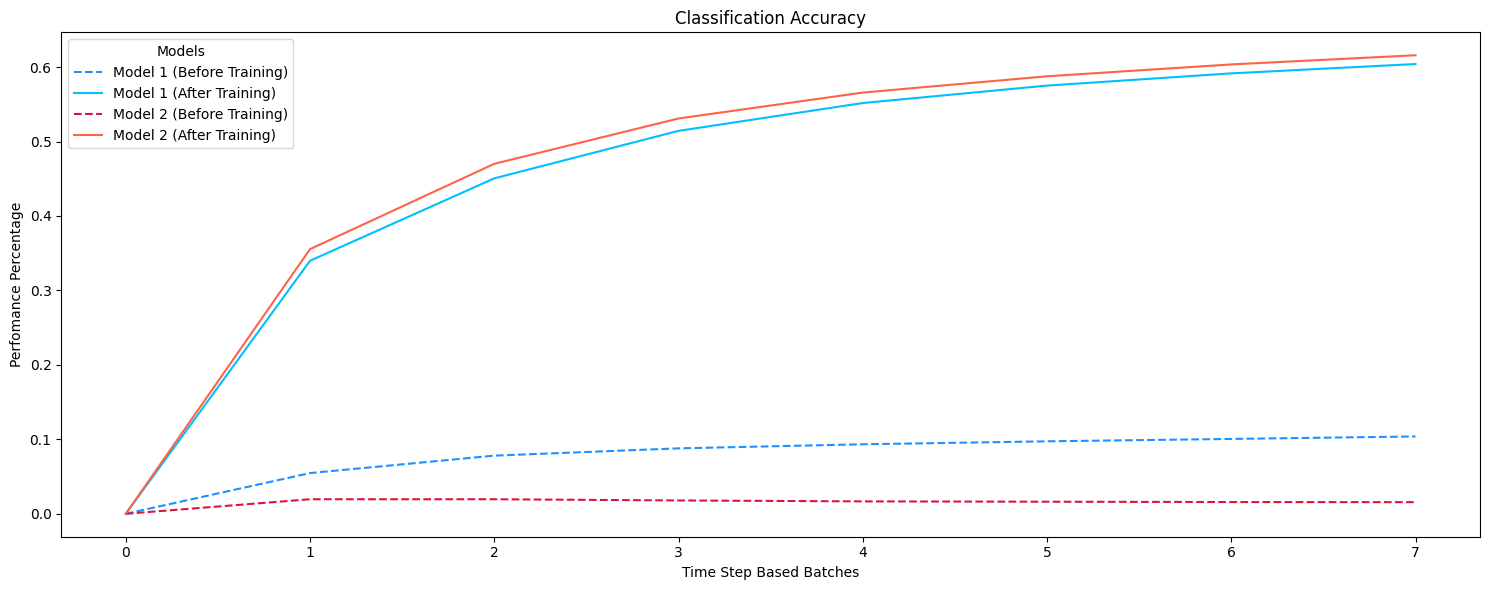

In [67]:
# plot out perfomance history
plt.figure(figsize=(15, 6))
plt.plot(bt_perm_norm, color='dodgerblue', linestyle ='dashed', label='Model 1 (Before Training)')
plt.plot(at_perm_norm, color='deepskyblue', linestyle ='solid', label='Model 1 (After Training)')
plt.plot(bt_perm_norm2, color='crimson', linestyle ='dashed', label='Model 2 (Before Training)')
plt.plot(at_perm_norm2, color='tomato', linestyle ='solid', label='Model 2 (After Training)')
plt.xlabel('Time Step Based Batches')
plt.ylabel('Perfomance Percentage')
plt.title('Classification Accuracy')
plt.legend(title='Models')
plt.tight_layout()

plt.show()